## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [ ]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-01-17 01:39:27--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2023-01-17 01:39:28 (29.0 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [1]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [3]:
# let's look at the first 1000 characters
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [8]:
# looks like andrey is training a decoder since he says, "18 means 47 is next", "18,47 ,means 56 is next", etc.

block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

### transformer trained on contexts of length 1 to block size
transformer predicts everything up to block size, after block size start truncating because transformer will never see > block size inputs when predicting next character



In [9]:
# decoder, attention to the previous outputs only, not forward and output the next word
# staggered indices for x an y so that the target is the next word
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


### send in mini batches of chunks of text when training
batches go into a single tensor of shape [batch_size, chunk_length] probably with padding.
GPU processes multiple chunks at same time

In [10]:
# pull out random chunks of text from the dataset
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # random offsets into dataset and get batch_size chunks of length block_size
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # stack to make rows in 4 * 8 tensor
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

### above when the training input is 
tensor([[24, 43, 58,  5, 57,  1, 46, 43]]),
### the decoder is fed the target
[[43, 58,  5, 57,  1, 46, 43, 39]],
<br>this creates the loss function by giving the correct answer for every single position inside of X, notice the staggering and overlap, ie. transformer tries to predict every single position in tensor Y based on the context provided in tensor X.

In [11]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # this embedding table is what gets trained, starting from random initialization
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        '''
        idx is inputs tensor of shape (B, T)
        targets is targets tensor of shape (B, T)
        '''

        # idx and targets are both (B,T) tensor of integers
        '''
        each input token looks up the embedding table and gets a row vector of size vocab_size, ie. 24 will extract the 24th row vector
        '''
        # B, T, C = batch, time, channels = 4, 8, 65 = batch, block size, vocab size, logits are the scores for the next character in sequence, ie. predict what's next based on the invididual identity of a single token
        logits = self.token_embedding_table(idx) # (B,T,C)
        # Pytorch wants B x C x T for the shape of the logits
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            # target is shape B* T before view, and B*T after view, can also do targets.view(-1)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
        
    def generate(self, idx, max_new_tokens):
        '''
        generates from (B,T) to t+1, t+2, t+3, ... t+max_new_tokens
        As is, it is being fed the entire sequence but only looks at the last token where as later we will feed it the entire sequence and it will look at all the tokens or further back into the sequence
        '''
        # idx is (B, T) array of indices in the current context
        # so idx gets longer by one token each iteration as the predicted token is appended to the running sequence
        for _ in range(max_new_tokens):
            # get the predictions without targets, generation after training
            logits, loss = self(idx)
            #print(f'logits shape befor reshape: {logits.shape}')
            # focus only on the last time step, -1 means pluck out the last time step, ie. the last token in the sequence, hhe last of the T dimension
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution, ie. sample from probs, probs is a distribution over the vocab, so sample from the distribution to get the next token
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
#expecting loss of -ln(1/65) = 4.1744, negatvie log likelihood, so at 4.87 the preditions are not diffuse but have entropy  , guessing wrong 
print(loss)

# try creating B=1, T=1, C=65, ie. a single token
#idx_test = torch.zeros((1, 1), dtype=torch.long)
# this produces garbage since the model is not trained
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


### above with commented out code,
Each prediction is of length vocab size, ie. the embedding row so given an input character that is the context, predicts the len 65 embedding?

# re. sampling from multinomial distribution

The `torch.multinomial` function samples from the multinomial distribution defined by the given probabilities, and it does not always choose the highest probability. Instead, it samples based on the distribution of probabilities, meaning that it will more often choose tokens with higher probabilities, but it can also choose tokens with lower probabilities.

### Multinomial Distribution

A multinomial distribution is a generalization of the binomial distribution. While the binomial distribution deals with the number of successes in a fixed number of independent Bernoulli trials, each with the same probability of success, the multinomial distribution deals with the number of times each outcome can occur in a fixed number of independent and identically distributed multinomial trials.

In the context of the code snippet you provided, the multinomial distribution is used to model the probability distribution over the vocabulary of tokens. The probabilities are given by the softmax function, which converts the logits into a probability distribution where the sum of the probabilities is 1.

### Visualization

You can visualize the multinomial distribution as a bar chart where each bar represents a different outcome (or token in this context), and the height of the bar represents the probability of that outcome. The probabilities must sum to 1, so the total area under the bars will be 1.

### Sampling vs. Argmax

If you were to always choose the highest probability, you would use the `argmax` function, which would always select the token with the highest probability. This would lead to deterministic behavior where the same input always produces the same output.

By using `torch.multinomial`, the code introduces randomness into the generation process, allowing for diversity in the generated text. It means that even if one token has the highest probability, there's still a chance to select other tokens based on their probabilities. This stochastic behavior can make the generation process more creative and less predictable, which is often desirable in tasks like text generation.

### Conclusion

The use of the multinomial distribution in the code snippet allows for a probabilistic sampling of tokens based on their probabilities. It introduces randomness into the generation process, allowing for a more diverse and creative output, as opposed to always selecting the token with the highest probability.

In [13]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

### train for 10k steps, decrease loss and try printing predictions

In [14]:
batch_size = 32
for steps in range(10000): # increase number of steps for good results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


2.5727508068084717


# before:
jFU,V.bERfOnmb;:b
S.DAckcLI'dFbOyGltRj$VrIJdT pxcbOTEi-RmYIVjhXlgi
D;HkQYQJBdSqe'hlvOmbFM?IgRhSPH-KJFbjxq-PyXxZRukyG:a-USPZJOda!BS?llv
xrtDrdlIKBL:3Z;lvN
xtTVwwBNfM?wLNclyagbjXeAyteQFd?qpxjuk!
RSJJb?pL?$GjN:CH;Ak!$zy,IkcOsrDWgia-YwLTPNeD'aHxBktLpwJdPkckI$Ocd,SRjfSArgCKCJvHg.?FEQJM?tiW'PBfNz;3CJ&y&skqoRSPmZAUj.eh rQNw3,O.jKHfNKH;Ea
CMm qbn?qeCjuktLXN.SPinuEmZvWLfZYCX:CJOdcuFwN.SVrqHAfSAHrbOciC fRpy;vv.?IcPdmZyzLvi-!XcOLjGJjL!qp'dcmZdu3fvieCPJhrI3fFIN!rulvW?$aSpCoRS.tKBOpgaP
SPWLjuCkgSpSncIq,bf:CE

In [15]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))

#tokens still not talking to each other


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghiybHen yof GLUCEN t l-t E:
I hisgothers je are!-e!
QLYotouciullle'z


# The mathematical trick in self-attention, 
####  use a lower triangular matrix and then normalize it then multiply it with the b matrix then c ends up being a matrix where the row elements are sums that accumulate the sums from previous rows up to the current element. This is faster than the loop way shown a few cells below

In [16]:
'''
Want tokens talking to each other but not to future tokens only previous ones, so at time t can take a feature vector that is the average of the C's at t-1, t-2, ... start token but lose lots of spatial info if just summing or averaging but it is okay for now.
'''
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
print(x.shape)
x[0]

torch.Size([4, 8, 2])


tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [17]:
# We want x[b,t] = mean_{i<=t} x[b,i], ie. get the mean of the C"s for each time step up to and including the current token 
'''
bow is bag of words used when averaging over the context, word stored in each of 8 locations of T, then averaged over the 8 locations for bow
'''
torch.manual_seed(1337)
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C), slice includes start to current token
        # average out over the first dimension, ie. the time steps
        xbow[b,t] = torch.mean(xprev, 0) # this is C, stored for the t-th token in the b-th batch (in the bag of words), ie. it's the context of the t-th token in the b-th batch which includes the t-th token and all the tokens before it


In [18]:
print(x.shape, xbow.shape)
print(f'x:\n {x[0]}\n xbow:\n {xbow[0]}')

torch.Size([4, 8, 2]) torch.Size([4, 8, 2])
x:
 tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
 xbow:
 tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


#### notice how the second row onwards of xbow is the average of the rows of x up to that row.

In [19]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


In [21]:
# torch has a trick for a lower triangular matrix
torch.tril(torch.ones(3,3))
torch.triu(torch.ones(3,3))

tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])

In [22]:
# now try using this in the math
torch.manual_seed(42)
#a = torch.ones(3,3)
# normalize rows of a so they sum to 1
a = torch.tril(torch.ones(3,3))
# normalize by dividing by the sum of each row
b = torch.randint(0,10,(3,2)).float()
print(f'b shape: {b.shape}')
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

b shape: torch.Size([3, 2])
a=
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


##### notice how the resulting c matrix are sums of the previous rows and current rows of b with last row being the sum of all rows of b

#### now normalize the lower triangular matrix to get the average of the previous tokens

In [23]:
torch.manual_seed(1337)
#a = torch.ones(3,3)
# normalize rows of a so they sum to 1
a = torch.tril(torch.ones(3,3))
# normalize by dividing by the sum of each row, divide by sum of 1st dim
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
print(f'b shape: {b.shape}')
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

b shape: torch.Size([3, 2])
a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[5., 7.],
        [2., 0.],
        [5., 3.]])
--
c=
tensor([[5.0000, 7.0000],
        [3.5000, 3.5000],
        [4.0000, 3.3333]])


#### now each row of c is the average of the rows of b up to it 

In [24]:
# now lets look at the weights matrix that averages the context words
torch.manual_seed(1337)
wei = torch.tril(torch.ones(T,T))
wei = wei / wei.sum(1, keepdim=True)

'''
Below do a (T,T) @ (B,T,C) matrix mult so Pytorch creates a B dimension making it (B,T,T) @ (B,T,C) = (B,T,C) doing all the matrix mults in parallel
'''
xbow2 = wei @ x #(B,T,T) @ (B,T,C) = (B,T,C)

#print(xbow2 - xbow) # should be zero
# adjust tolerance
torch.allclose(xbow, xbow2, atol=1e-6, rtol=1e-3) # should be True

True

In [25]:
xbow[0] == xbow2[0]

tensor([[ True,  True],
        [ True,  True],
        [ True, False],
        [ True, False],
        [ True, False],
        [False,  True],
        [False, False],
        [False,  True]])

In [26]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
xbow2 

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])

In [28]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
# how much of the tokens from the past do I want to aggregate?  ie. affinities are data dependent and some tokens are more important than others to the one doing the looking depending on their values, affinities
wei = torch.zeros((T,T))
# convert all 0's to -inf, ie. don't aggregate anythign in the future
wei = wei.masked_fill(tril == 0, float('-inf'))
# softmax is also a normalization so end up with the same matrix
wei = F.softmax(wei, dim=-1)
# normalize and sume, ie. aggregate values depending on how interesting the tokens find each other
xbow3 = wei @ x
torch.allclose(xbow, xbow3, atol=1e-6, rtol=1e-3) # should be True
# the elements of the lower triangular matrix tell me how much of the elements fuses into the current token, use this for the self attention

True

## Self attention below for single head
video: 1:02

##### previously was using lower triangular normalized matrix to get the cululative averages up to the token, ie. all previous tokens info as averages included,  but actually don't want the wei matrix to be all uniform because tokens find certain other tokens more interesting.  
ex. vowels may look for consonants and want that info to flow to me

##### Attention solves this by having each token emit a query and key, 
query asks what am I looking for and key says, "What do I contain?"

##### Get affinities by doing dot products between keys and queries 
and the dot product becomes "wei", key and query are aligned and interact to a "high amount"? and then learn more about that token as opposed to any other token in sequence.  







In [29]:
# version 4: self-attention!
# key and value produced from same input as query
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels, each token has info of dim 32
# x is the input where an encoding is converted via the embedding layer and the C consists of the embedding dim which is the vocab size
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 # hyperparam
# bias is False so just do matrix multiply with fixed weights
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
# get k and q by forwarding x through the linear layers
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
# communication between k and q happen next, creates a T^2 matrix of affinities at each row of B 
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
# aggregate value(x) rather than raw x
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

# Q. What actually gets trained?
Oh, I see. So when you're multiplying, or when it says nn.linear, bracket c, head size, bias equals false, and you're running x through that, it's actually c is a set of nodes, and then x is a set of nodes, and then there's parameters in between them, d, and those are the weights being trained. Is that correct?

# A. 
Yes, you've got it right! When using `nn.Linear(c, head_size, bias=False)` and applying it to the input `x`, the following is happening:

- `c`: This is the input feature size, which corresponds to the dimensionality of each token in your input `x` with shape (B, T, C).
- `head_size`: This is the output feature size, which will determine the dimensionality of the output after the linear transformation (e.g., the dimensionality of the queries, keys, and values).
- `bias=False`: Indicates that no bias term is added in the transformation.
- The weight matrix within this `nn.Linear` layer will have a shape of (c, head_size), and these are the weights that will be trained. This matrix is initialized randomly and gets updated through backpropagation during training.

So in essence, the linear layer is taking the input `x` of shape (B, T, C) and transforming it to a new representation with shape (B, T, head_size) by multiplying with the weight matrix (C, head_size). These weight matrices for producing queries (Q), keys (K), and values (V) are the trainable parameters in the attention mechanism of the transformer.

## More on what actually gets trained in a Transformer: 
#### remembering that key, value and query matrices are created by running x through nn.Linear(), see the code above in the simplified example

From ChatGPT:

Certainly! In the context of the transformer's attention mechanism and the code snippet `nn.Linear(C, head_size, bias=False)`, here's a breakdown of the dimensions:

- **C**: This represents the dimensionality of each token in the input `X`. In other words, it's the number of features for each token, often referred to as the embedding size or hidden dimension.

- **head_size**: This is the size of each attention head. In multi-head attention, the total key, query, and value dimensionality is often divided across multiple heads.

- **X**: The input to this linear layer, typically with shape `(B, T, C)` where:
  - **B**: Number of batches
  - **T**: Number of time steps or sequence length
  - **C**: Feature size, as mentioned above

Now, the dimensions of the key, value, and query after running through this linear layer would be:

- **Key (K)**: Shape `(B, T, head_size)`
- **Query (Q)**: Shape `(B, T, head_size)`
- **Value (V)**: Shape `(B, T, head_size)`

If you are dealing with multi-head attention, you may further split these into multiple heads, in which case the dimensions would be reshaped accordingly. For example, if there are `num_heads` heads, you might reshape each of these matrices to `(B, num_heads, T, head_size // num_heads)`.

Note: The actual dimensions may vary based on implementation details and specific design choices, such as whether you're using multi-head attention. The above outlines a common arrangement based on the information provided.

#### more clarification on the what actually gets trained:

In the transformer's attention mechanism, the terms "query," "key," and "value" refer to different projections of the input. They are typically derived by applying linear transformations to the input data. Let's break down the specifics of what's happening:

1. **Input Shape (B, T, C)**: The input `x` has shape (B, T, C), where B is the batch size, T is the sequence length (number of time steps), and C is the dimensionality of each token (sometimes referred to as the "context" or "channels").

2. **Linear Transformation**: The `nn.Linear` layer in PyTorch performs a linear transformation. It takes an input of size (in_features) and produces an output of size (out_features), according to the equation:
   \[
   \text{output} = \text{input} \times W + b
   \]
   where `W` is a weight matrix of size (in_features, out_features), and `b` is a bias vector (if bias is not turned off). These are the trainable parameters.

3. **Creating Q, K, V**: The keys (K), queries (Q), and values (V) are produced by applying different linear transformations to the input `x`. This means multiplying the input by different weight matrices (and possibly adding biases). These weight matrices are the trainable parameters, and they are different for each of the transformations that produce Q, K, and V. The fact that he's using `C` from the BTC shape as the input dimensionality to `nn.Linear` simply means that the weight matrices for these transformations have `C` rows.

The term "context" here doesn't refer to the weights themselves but to the dimensionality of each token. The weights are the elements of the matrices used in the linear transformations that produce Q, K, and V, and they are what gets trained.

The process can be visualized like this:

- Input `x`: Shape (B, T, C)
- Apply linear transformation to create Q: Weight matrix shape (C, d), resulting Q shape (B, T, d)
- Apply linear transformation to create K: Weight matrix shape (C, d), resulting K shape (B, T, d)
- Apply linear transformation to create V: Weight matrix shape (C, d), resulting V shape (B, T, d)

Here, `d` would be the dimensionality of the queries, keys, and values, and it's a hyperparameter of the model. The weight matrices with shape (C, d) are the trainable parameters in this part of the model.

In [30]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

### Notice above that the rows are not evenly distributed now but some probs are higher than others

So the 0.2391 in the bottom right is the eight token and knows what content it has and knows what position it's in.  Based on that it creates a query.  "I'm a vowel in 8th position looking for any consonants in positions up to 4".  All the nodes emit keys and one might say, "I am a consonant in position up to 4" and that key would have a high nubmer in that specific channel.  So that key and the vowel's query can create a high affinity when they dot product.  <br>

[0.2297, 0.0573, 0.0709, 0.2423, 0.2391] so the 0.2297 is of high interest to the 8th token and when they have high affinity, through softmax can aggregate a lot of its info into my position, ie. learn a lot about it.  
The result of the softmax equals 1 so tells you how much info from each of the past tokens to aggregate into the current token.  

### We don't aggregate the tokens but aggregate the value
x (is a vector) is private information to the token.  key is "here is what I have", query is "here is what I"m interested in" and value is "here is what I will communicate to you"

v is what gets aggregated for the purposes of this single head.




Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

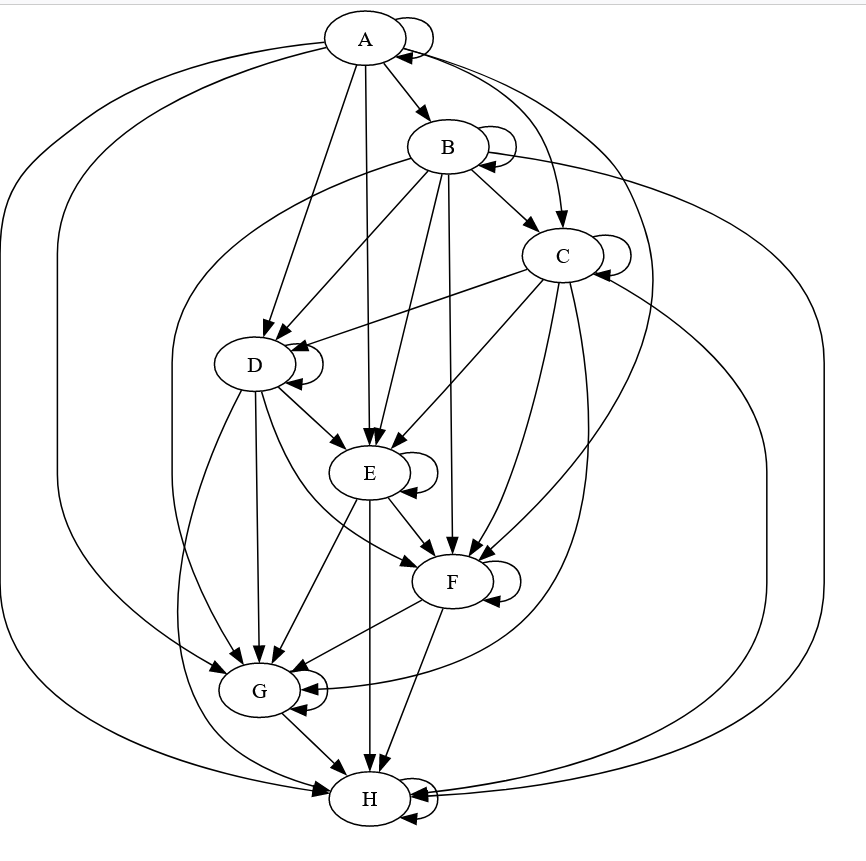

- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below
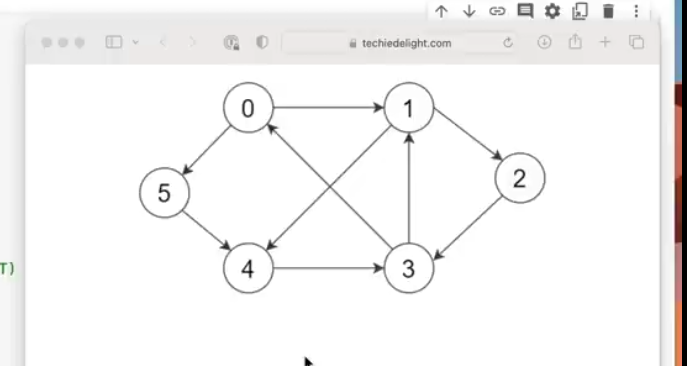

In [37]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

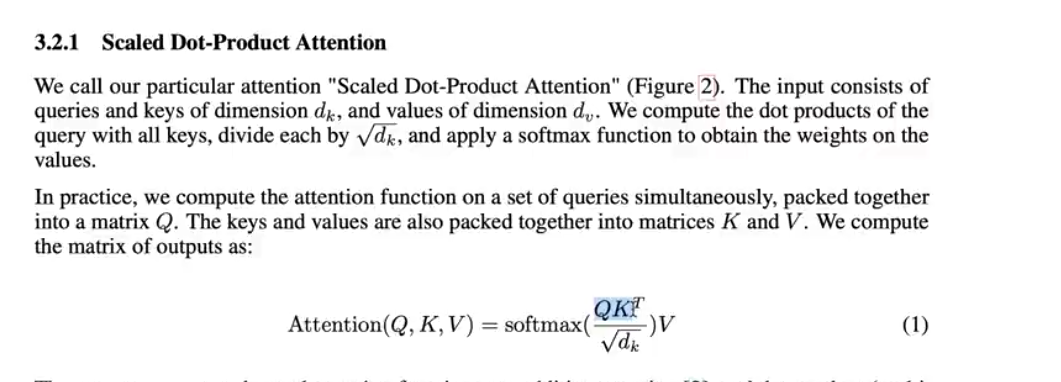

The original paper advocates for dividing by the square root of the head size in order to keep the values fed into softmax close to zero because once those values get too big, Softmax becomes too peeky and then each token would only be getting context from one other token.  

In [38]:
k.var()

tensor(1.0001)

In [39]:
q.var()

tensor(0.9428)

In [40]:
wei.var()

tensor(1.1663)

#### preserving variance of wei to be 1 by dividing by square root of head size, otherwise it gets up to about 17 in the video at 1:17:56

In [41]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [42]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

### can see above in final calculation that a 0.8000 is bad especially at initialization

In [36]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table, n_embed is number of embedding dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        # token embeddings to logits
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C) "embed C"
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        # differences between embed C and vocab_size C
        logits = self.lm_head(x) # (B,T,C=vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4198, val loss 2.4340
step 400: train loss 2.3503, val loss 2.3567
step 500: train loss 2.2970, val loss 2.3136
step 600: train loss 2.2410, val loss 2.2506
step 700: train loss 2.2062, val loss 2.2198
step 800: train loss 2.1638, val loss 2.1871
step 900: train loss 2.1232, val loss 2.1494
step 1000: train loss 2.1020, val loss 2.1293
step 1100: train loss 2.0704, val loss 2.1196
step 1200: train loss 2.0382, val loss 2.0798
step 1300: train loss 2.0249, val loss 2.0640
step 1400: train loss 1.9922, val loss 2.0354
step 1500: train loss 1.9707, val loss 2.0308
step 1600: train loss 1.9614, val loss 2.0474
step 1700: train loss 1.9393, val loss 2.0130
step 1800: train loss 1.9070, val loss 1.9943
step 1900: train loss 1.9057, val loss 1.9871
step 2000: train loss 1.8834, val loss 1.9954
step 2100: train loss 1.

# Some other points to consider with Transformers


# Q.
So I also saw a video saying that transformers are able to generalize much better than convolutional neural networks or MLPs or other types of neural networks. What's your opinion here?

# A.
Transformers have indeed demonstrated remarkable success across various tasks, outperforming other architectures like Convolutional Neural Networks (CNNs) and Multi-Layer Perceptrons (MLPs) in many instances. However, the comparison depends on the context and the specific task at hand. Here's a general overview of how transformers might have advantages over other architectures:

1. **Sequential Data Processing**: Transformers are designed to handle sequential data without recurrence, capturing dependencies regardless of their distance in the sequence. This ability allows them to generalize well across various natural language processing (NLP) tasks.

2. **Parallelization**: Unlike Recurrent Neural Networks (RNNs), transformers can process all the tokens in a sequence simultaneously. This parallelization makes them highly efficient for training, potentially leading to better performance.

3. **Attention Mechanism**: The attention mechanism allows transformers to weigh the importance of each part of the input when making predictions. This flexibility enables them to capture complex relationships and dependencies, improving generalization.

4. **Scalability**: Transformers have been shown to benefit from increasing model size, leading to the development of extremely large models like GPT-3, which have achieved state-of-the-art performance on various benchmarks.

5. **Versatility**: Transformers have proven effective not only in NLP but also in computer vision and other domains, showcasing their ability to generalize across different types of data.

However, it's essential to note that transformers may not always be the best choice:

- **Data Efficiency**: Transformers often require large amounts of data to train effectively, whereas other architectures like CNNs might be more data-efficient for specific tasks (e.g., image classification).
- **Computational Overhead**: The complexity of the self-attention mechanism can lead to substantial computational requirements, particularly for long sequences. This might make transformers less suitable for resource-constrained scenarios.

In summary, transformers indeed have the potential to generalize well and outperform other architectures in many scenarios, especially when it comes to handling sequential data and complex relationships. However, the choice of architecture should always be guided by the specific problem, available data, computational resources, and other task-specific considerations.

# Q.
I'm mainly concerned with the computational overhead because of all the dot products happening with attention. It seems like you need to have a lot of memory to store all that. Is this true?

# A.
Yes, your concern is valid. The attention mechanism in transformers can indeed lead to substantial computational overhead, both in terms of computation and memory requirements. Let's break down the aspects contributing to this overhead:

1. **Matrix Multiplication**: The attention mechanism involves multiplying the query, key, and value matrices, leading to a significant number of matrix multiplications. This operation can be computationally intensive, especially when dealing with large sequences and high-dimensional vectors.

2. **Storage of Attention Weights**: The self-attention process computes attention scores for every pair of tokens in the sequence. Storing these scores requires memory that grows quadratically with the sequence length (O(n^2)), where n is the number of tokens in the sequence. This can become a significant limitation for long sequences.

3. **Multiple Heads**: Many transformer models utilize multi-head attention, which compounds the computational and memory requirements by performing the attention computation across multiple "heads" simultaneously. 

4. **Batch Processing**: Processing multiple sequences simultaneously as a batch can further increase the memory requirements, as you need to store intermediate values for each sequence in the batch.

5. **Large Models**: Transformers often contain a large number of parameters, especially in state-of-the-art models. Storing these parameters, along with the gradients during training, can also contribute to high memory usage.

This computational and memory overhead has led to challenges in training and deploying transformers, especially on long sequences or when using resource-constrained devices. Various optimizations and techniques have been developed to address these challenges:

- **Gradient Checkpointing**: Reduces memory requirements during training by recomputing intermediate values rather than storing them.
- **Model Pruning**: Reducing the model's size by removing less important parameters.
- **Model Distillation**: Training smaller models to mimic the behavior of a larger model.
- **Sparse Attention Patterns**: Using sparsity in the attention mechanism to reduce the computational and memory complexity.

While these techniques can mitigate the computational overhead, it's essential to carefully consider the trade-offs in terms of efficiency, accuracy, and complexity when selecting and optimizing a transformer model for a specific task or platform.